In [12]:
import numpy as np
import pandas as pd
from scipy import stats as stats
from matplotlib import pyplot as plt

In [13]:
sample_size = 201
df = pd.DataFrame()
df["k"] = np.arange(sample_size)
h = 0.05
df["nois"] = stats.norm.rvs(size=sample_size)
df["true_trend"] = np.sqrt(df["k"] * h)
df["x"] = df["true_trend"] + df["nois"]
windows = [21, 51, 111]
df

,k,nois,true_trend,x
0,0,0.792851,0.000000,0.792851
1,1,-1.011445,0.223607,-0.787838
2,2,-0.168596,0.316228,0.147632
3,3,-0.435832,0.387298,-0.048534
4,4,-1.138787,0.447214,-0.691574
...,...,...,...,...
196,196,0.560882,3.130495,3.691377
197,197,-0.338820,3.138471,2.799650
198,198,1.264800,3.146427,4.411226
199,199,0.833411,3.154362,3.987773


In [14]:
# rolling metric
def rollingm(x: pd.Series, windows: list, metric: str, true_trend: pd.Series = None,  *args, **kwargs) -> list:
    fig, axs = plt.subplots(len(windows))
    fig.suptitle(metric)
    trends = []
    for i, window in enumerate(windows):
        trends.append(x.rolling(window=window, center=True, min_periods=None).__getattribute__(metric)())
        axs[i].plot(trends[-1])
        if not true_trend is None:
            axs[i].plot(true_trend)
        axs[i].grid()
    return trends


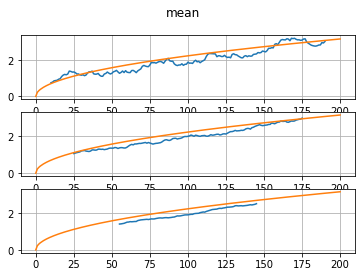

In [15]:
# mean
mean_trends = rollingm(df["x"], windows, "mean", df["true_trend"])

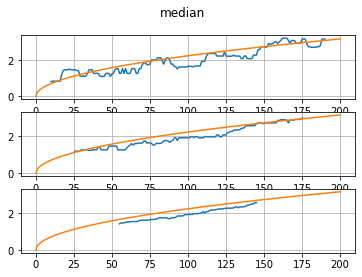

In [16]:
median_trends = rollingm(df["x"], windows, "median", df["true_trend"])

In [17]:
# turning points method
def turning_points(series: pd.Series, trend: pd.Series) -> tuple:
    rem = np.array((series - trend).dropna())
    points = []
    for i in range(1, len(rem) - 1):
        if rem[i-1] is pd.NA or rem[i] is pd.NA or rem[i+1] is pd.NA:
            continue
        if (rem[i-1] < rem[i] and rem[i] > rem[i+1]) or (rem[i-1] > rem[i] and rem[i] < rem[i+1]):
            points.append(1)
        else:
            points.append(0)
    return sum(points), (len(points) - 2) * 2 / 3
    

In [18]:
# Kendal method
def kendal(series: pd.Series, trend: pd.Series):
    rem = np.array((series - trend).dropna())
    n_revers = 0;
    for i in range(len(rem)):
        for j in range(i + 1, len(rem)):
            if rem[j] > rem[i]:
                n_revers += 1
    return 4 * n_revers / (len(rem) * (len(rem) - 1)) - 1

In [19]:
trends = mean_trends + median_trends
for i, trend in enumerate(trends):
    print("mean" if i // len(windows) == 0 else "median")
    print(f"window={windows[i % len(windows)]}")
    print(f"E[p], E[pc] = {turning_points(df['x'], trend)}")
    print(f"kendal coefficient = {kendal(df['x'], trend)}")
    print()


mean
window=21
E[p], E[pc] = (106, 118.0)
kendal coefficient = -0.01362799263351755

mean
window=51
E[p], E[pc] = (86, 98.0)
kendal coefficient = 0.004856512141280245

mean
window=111
E[p], E[pc] = (52, 58.0)
kendal coefficient = -0.02857142857142858

median
window=21
E[p], E[pc] = (108, 118.0)
kendal coefficient = -0.0049109883364026885

median
window=51
E[p], E[pc] = (86, 98.0)
kendal coefficient = -0.0023841059602649484

median
window=111
E[p], E[pc] = (52, 58.0)
kendal coefficient = -0.02271062271062274

